## 데이터 불러오기

In [1]:
import pandas as pd

In [3]:
data = pd.read_csv('./data_eda02_final.csv')
data.drop('Unnamed: 0', axis=1, inplace=True)

In [4]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np

target = 'label'
x = data.drop(target, axis=1)
y = data.loc[:, target]
x.shape, y.shape

((1239, 11), (1239,))

In [5]:
ohe_y = to_categorical(y, 2)

### (1) Functional API로 모델 만들기

In [6]:
from tensorflow.keras.backend import clear_session
from tensorflow.keras.layers import Layer, Input, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
import tensorflow as tf

INPUT_SIZE= 11
def create_model():
    clear_session()
    input_tensor = Input(shape=(INPUT_SIZE, ))
    x = Flatten()(input_tensor)
    x = Dense(128, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    output = Dense(2, activation='sigmoid')(x)

    model = Model(input_tensor, output)
    return model

In [7]:
# test
model = create_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 11)]              0         
                                                                 
 flatten (Flatten)           (None, 11)                0         
                                                                 
 dense (Dense)               (None, 128)               1536      
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                                 
 dense_2 (Dense)             (None, 2)                 66        
                                                                 
Total params: 5,730
Trainable params: 5,730
Non-trainable params: 0
_________________________________________________________________


### train, test데이터 분리

In [8]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, ohe_y, test_size=0.3, random_state=2023)

In [9]:
print(f'x_train.shape: ', x_train.shape)
print(f'y_train.shape: ', y_train.shape)
print(f'x_test.shape: ', x_test.shape)
print(f'y_test.shape: ', y_test.shape)

x_train.shape:  (867, 11)
y_train.shape:  (867, 2)
x_test.shape:  (372, 11)
y_test.shape:  (372, 2)


### 모델 생성과 compile

In [10]:
from tensorflow.keras.optimizers import Adam

model = create_model()
model.summary()
model.compile(optimizer=Adam(0.001), loss='binary_crossentropy',
              metrics=['accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 11)]              0         
                                                                 
 flatten (Flatten)           (None, 11)                0         
                                                                 
 dense (Dense)               (None, 128)               1536      
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                                 
 dense_2 (Dense)             (None, 2)                 66        
                                                                 
Total params: 5,730
Trainable params: 5,730
Non-trainable params: 0
_________________________________________________________________


In [14]:
!pip install pydot
!pip install graphviz

In [15]:
plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [16]:
history = model.fit(x=x_train, y=y_train, batch_size=32, epochs=100, validation_split=0.2)

Epoch 1/100
22/22 [==============================] - 1s 14ms/step - loss: 0.7715 - accuracy: 0.6768 - val_loss: 0.5176 - val_accuracy: 0.7356
Epoch 2/100
22/22 [==============================] - 0s 3ms/step - loss: 0.4578 - accuracy: 0.7864 - val_loss: 0.4483 - val_accuracy: 0.8103
Epoch 3/100
22/22 [==============================] - 0s 3ms/step - loss: 0.4218 - accuracy: 0.7951 - val_loss: 0.3801 - val_accuracy: 0.8448
Epoch 4/100
22/22 [==============================] - 0s 3ms/step - loss: 0.3543 - accuracy: 0.8644 - val_loss: 0.3367 - val_accuracy: 0.8851
Epoch 5/100
22/22 [==============================] - 0s 3ms/step - loss: 0.3346 - accuracy: 0.8716 - val_loss: 0.3171 - val_accuracy: 0.8621
Epoch 6/100
22/22 [==============================] - 0s 3ms/step - loss: 0.3023 - accuracy: 0.8817 - val_loss: 0.2882 - val_accuracy: 0.8966
Epoch 7/100
22/22 [==============================] - 0s 3ms/step - loss: 0.2740 - accuracy: 0.9091 - val_loss: 0.2717 - val_accuracy: 0.8966
Epoch 8/100


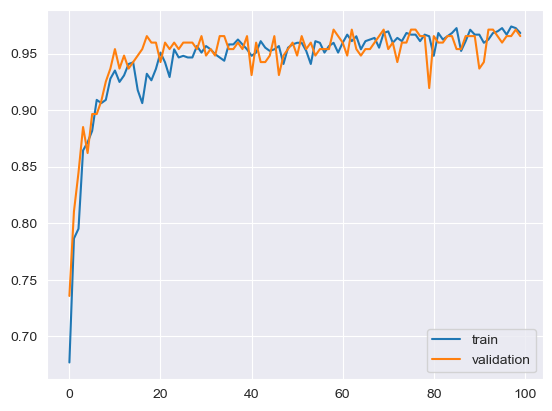

In [17]:
import matplotlib.pyplot as plt

def show_history(history):
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='validation')
    plt.legend()
show_history(history)

In [18]:
# 테스트 데이터 세트로 모델 성능 검출
y_pred = model.evaluate(x_test, y_test, batch_size=128, verbose=1)
print(f'y_pred: loss값 :', y_pred[0])
print(f'y_pred: accuracy값: ', y_pred[1])

3/3 [==============================] - 0s 2ms/step - loss: 0.2724 - accuracy: 0.9194
y_pred: loss값 : 0.27237147092819214
y_pred: accuracy값:  0.9193548560142517


### callback 사용

In [20]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

model = create_model()
model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

mcp_cb = ModelCheckpoint(filepath='working/weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss',
                         save_best_only=True, save_weights_only=True, mode='min', period=1, verbose=0)
rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, mode='min', verbose=1)
ely_cb = EarlyStopping(monitor='val_loss', patience=7, mode='min', verbose=1)

history = model.fit(x=x_train, y=y_train, batch_size=32, epochs=1000, validation_split=0.2, callbacks=[mcp_cb, rlr_cb, ely_cb])

Epoch 1/1000
22/22 [==============================] - 1s 12ms/step - loss: 0.6844 - accuracy: 0.6753 - val_loss: 0.7148 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 2/1000
22/22 [==============================] - 0s 3ms/step - loss: 0.5036 - accuracy: 0.7374 - val_loss: 0.4592 - val_accuracy: 0.7759 - lr: 0.0010
Epoch 3/1000
22/22 [==============================] - 0s 3ms/step - loss: 0.4107 - accuracy: 0.8211 - val_loss: 0.4149 - val_accuracy: 0.8563 - lr: 0.0010
Epoch 4/1000
22/22 [==============================] - 0s 3ms/step - loss: 0.3610 - accuracy: 0.8629 - val_loss: 0.3481 - val_accuracy: 0.8678 - lr: 0.0010
Epoch 5/1000
22/22 [==============================] - 0s 3ms/step - loss: 0.3227 - accuracy: 0.8802 - val_loss: 0.3127 - val_accuracy: 0.8793 - lr: 0.0010
Epoch 6/1000
22/22 [==============================] - 0s 3ms/step - loss: 0.2959 - accuracy: 0.8846 - val_loss: 0.3107 - val_accuracy: 0.8908 - lr: 0.0010
Epoch 7/1000
22/22 [==============================] - 0s 3ms/step - l

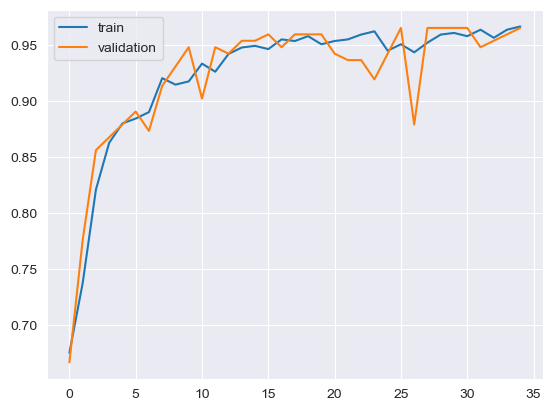

In [21]:
show_history(history)

In [22]:
y_pred = model.evaluate(x_test, y_test, batch_size=128, verbose=1)
print(f'y_pred: loss값 :', y_pred[0])
print(f'y_pred: accuracy값: ', y_pred[1])

3/3 [==============================] - 0s 2ms/step - loss: 0.2254 - accuracy: 0.9167
y_pred: loss값 : 0.2253740131855011
y_pred: accuracy값:  0.9166666865348816
